In [91]:
import cobra
import pandas as pd 
import numpy as np
import os
from os.path import join
from cobra.util import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import pfba
from time import sleep
from cobra.flux_analysis import flux_variability_analysis
from efflux_method import Eflux


In [92]:
model_name = "4_universal_mito_model.xml"
model = cobra.io.read_sbml_model("4_universal_mito_model.xml")

In [93]:
reaction_list = [reaction.id for reaction in model.reactions]
total_reactions = len(reaction_list)
print("Total number of reactions:", total_reactions)
print("List of reactions:", reaction_list)

Total number of reactions: 560
List of reactions: ['EX_2hb_e', 'EX_ac_e', 'EX_acac_e', 'EX_akg_e', 'EX_ala_B_e', 'EX_ala_L_e', 'EX_arg_L_e', 'EX_argsuc_e', 'EX_asn_L_e', 'EX_asp_L_e', 'EX_bhb_e', 'EX_bilirub_e', 'EX_biomass_e', 'EX_but_e', 'EX_chol_e', 'EX_cit_e', 'EX_citr_L_e', 'EX_co_e', 'EX_co2_e', 'EX_creat_e', 'EX_cyan_e', 'EX_cys_L_e', 'EX_etoh_e', 'EX_fe2_e', 'EX_for_e', 'EX_fum_e', 'EX_glc_D_e', 'EX_gln_L_e', 'EX_glu_L_e', 'EX_gly_e', 'EX_glyc_e', 'EX_h_e', 'EX_h2o_e', 'EX_HC00250_e', 'EX_hco3_e', 'EX_hdca_e', 'EX_his_L_e', 'EX_icit_e', 'EX_ile_L_e', 'EX_lac_L_e', 'EX_leu_L_e', 'EX_lys_L_e', 'EX_mal_L_e', 'EX_mercplac_e', 'EX_met_L_e', 'EX_nad_e', 'EX_nadh_e', 'EX_nh4_e', 'EX_no_e', 'EX_o2_e', 'EX_oaa_e', 'EX_pchol_hs_e', 'EX_pcreat_e', 'EX_pe_hs_e', 'EX_phe_L_e', 'EX_pi_e', 'EX_ppa_e', 'EX_pro_L_e', 'EX_ps_hs_e', 'EX_ser_L_e', 'EX_so3_e', 'EX_succ_e', 'EX_tcynt_e', 'EX_thr_L_e', 'EX_trp_L_e', 'EX_tsul_e', 'EX_tyr_L_e', 'EX_urea_e', 'EX_val_L_e', 'EX_fol_e', 'OF_ATP_mitoMap', '

In [94]:
reaction_ids = []
reaction_names = []
reaction_equations = []


for reaction in model.reactions:
    reaction_ids.append(reaction.id)
    reaction_names.append(reaction.name)
    reaction_equations.append(reaction.reaction)


for i in range(total_reactions):
    print(f"Reaction {i + 1}:")
    print("ID:", reaction_ids[i])
    print("Name:", reaction_names[i])
    print("Equation:", reaction_equations[i])
    print("-" * 40)

Reaction 1:
ID: EX_2hb_e
Name: EX_2hb_e
Equation: 2hb_e <=> 
----------------------------------------
Reaction 2:
ID: EX_ac_e
Name: EX_ac_e
Equation: ac_e <=> 
----------------------------------------
Reaction 3:
ID: EX_acac_e
Name: EX_acac_e
Equation: acac_e <=> 
----------------------------------------
Reaction 4:
ID: EX_akg_e
Name: EX_akg_e
Equation: akg_e <=> 
----------------------------------------
Reaction 5:
ID: EX_ala_B_e
Name: EX_ala_B_e
Equation: ala_B_e <=> 
----------------------------------------
Reaction 6:
ID: EX_ala_L_e
Name: EX_ala_L_e
Equation: ala_L_e <=> 
----------------------------------------
Reaction 7:
ID: EX_arg_L_e
Name: EX_arg_L_e
Equation: arg_L_e <=> 
----------------------------------------
Reaction 8:
ID: EX_argsuc_e
Name: EX_argsuc_e
Equation: argsuc_e <=> 
----------------------------------------
Reaction 9:
ID: EX_asn_L_e
Name: EX_asn_L_e
Equation: asn_L_e <=> 
----------------------------------------
Reaction 10:
ID: EX_asp_L_e
Name: EX_asp_L_e
Equa

In [95]:
#Stephen's corrected version
import csv

reaction_id = []
reaction_names = []
reaction_equation = []

for reaction in model.reactions:
    reaction_id.append(reaction.id)
    reaction_names.append(reaction.name)
    reaction_equation.append(reaction.reaction)

csv_file = "reactiondummy.csv"

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Reaction ID", "Reaction Name", "Reaction Equation"])
    for r_id, r_name, r_eq in zip(reaction_id, reaction_names, reaction_equation):
        writer.writerow([r_id, r_name, r_eq])

print(f"Data successfully saved to {csv_file}")


Data successfully saved to reactiondummy.csv


In [96]:
reactions_df = pd.read_csv('reaction.csv') 

atp_reactions_df = reactions_df[reactions_df['Reaction Equation'].str.contains("atp", case=False, na=False)]


print(atp_reactions_df)

        Reaction ID                                      Reaction Name  \
70   OF_ATP_mitoMap  R_OF_ATP_mitoMap Maximum ATP production (ATP h...   
74             HEX1  R_HEX1 ATP + alpha-D-Glucose --> ADP + alpha-D...   
77              PFK  R_PFK ATP + beta-D-Fructose 6-phosphate --> AD...   
82              PGK  R_PGK ATP + 3-Phospho-D-glycerate --> ADP + 3-...   
85              PYK  R_PYK ADP + Phosphoenolpyruvate --> ATP + Pyru...   
104         SUCOASm  R_SUCOASm ATP + Succinate + CoA --> ADP + Orth...   
111      CV_mitoMap                          R_CV_mitoMap ATP synthase   
113             PCm  R_PCm ATP + Pyruvate + HCO3- --> ADP + Orthoph...   
117  ACITLm_mitoMap  R_ACITLm_mitoMap ATP + Citrate + CoA --> ADP +...   
118          NDPK1m                   R_NDPK1m ATP + GDP --> ADP + GTP   
120           ADK1m                        R_ADK1m ATP + AMP --> 2 ADP   
123           NDPK1                    R_NDPK1 ATP + GDP --> ADP + GTP   
125            ADK1                   

In [97]:
solution = model.optimize()
print(solution)

<Solution 100.892 at 0x17ce1f980>


In [98]:
solution.objective_value

100.89230387215605

In [99]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
acac_e,EX_acac_e,0.114,4,2.74%
ala_L_e,EX_ala_L_e,0.01,3,0.18%
arg_L_e,EX_arg_L_e,0.007,6,0.25%
asn_L_e,EX_asn_L_e,0.01,4,0.24%
asp_L_e,EX_asp_L_e,0.154,4,3.70%
bhb_e,EX_bhb_e,0.048,4,1.15%
cys_L_e,EX_cys_L_e,0.001,3,0.02%
glc_D_e,EX_glc_D_e,0.9,6,32.44%
gly_e,EX_gly_e,0.009,2,0.11%
glyc_e,EX_glyc_e,0.01,3,0.18%


In [100]:
import pandas as pd

# Load the heart-specific data
heart_data = pd.read_csv("Heart_data.tsv", sep="\t")

# Display the first few rows
print(heart_data.head())
heart_data.columns = ["gene_id", "expression"]



   ENSMUSG00000031174  0
0  ENSMUSG00000031137  0
1  ENSMUSG00000094345  0
2  ENSMUSG00000096632  0
3  ENSMUSG00000093861  0
4  ENSMUSG00000076573  0


In [101]:


def perform_FBA(id_gene, id_value, human, constant, objective_id):
    """This function open the model, constrain it with Omics data (human or not) and optimise the model with the selected objective function
    args:
        id_gene (int): position of the gene identifier in the dataframe
        id_value (int): position of the value in the dataframe
        human (bool): constrain data on humain or mouse data
        constant (int): constant value used to scale the constrain (only to make the value easier for human)
        objective_id (id): identifier of the objective function in the model
    return:
        model (cobra.core.model): a constrained model
        pfba (cobra.Solution.solution): solution of parsimonious FBA
    """
    model = cobra.io.read_sbml_model(join("4_universal_mito_model.xml"))
    list_of_genes = []
    for gene in model.genes:
        list_of_genes.append(gene.id)
    heart_data = "Heart_data.tsv" 
    data_dictionary = pd.read_csv(heart_data,
                                  sep="\t")
    #
    model.objective = model.reactions[objective_id]
    Eflux(model, data_dictionary, constant, 1, ignore_human=not human, ignore_mus=human)
    exch, const = 0, 0
    for react in model.reactions:
        if react.bounds[1] == constant:
            const += 1
        elif react.bounds[1] == 1000:
            exch += 1

    return [model, pfba(model)]

result_Heart = perform_FBA(0, 1, True, 50, 70) 

488


In [102]:
model = result_Heart[0]
c=0
e=0
for reaction in model.reactions:
    c+= reaction._upper_bound != 500.0 and reaction._upper_bound != 1000.0
    e+= reaction._upper_bound == 1000.0
u = len(model.reactions) - c - e
print(f"There are :{c} constrained reactions\n           {u} unconstrained reactions\n           {e} exchange reactions")

There are :488 constrained reactions
           0 unconstrained reactions
           72 exchange reactions


In [103]:
result_Heart[0].summary()
#set the objective function and reperform fba

Metabolite,Reaction,Flux,C-Number,C-Flux
hdca_e,EX_hdca_e,0.002702,16,0.21%
o2_e,EX_o2_e,10.13,0,0.00%
pro_L_e,EX_pro_L_e,4.042,5,99.79%
Metabolite,Reaction,Flux,C-Number,C-Flux
biomass_e,EX_biomass_e,-50,0,0.00%
cit_e,EX_cit_e,-0.02162,6,0.64%
co2_e,EX_co2_e,-4.042,1,19.96%
h2o_e,EX_h2o_e,-0.01621,0,0.00%
h_e,EX_h_e,-4.036,0,0.00%
mal_L_e,EX_mal_L_e,-4.02,4,79.40%


In [104]:
cardiac_uptake_metabolites = ['hexadecanoate', 'O2', 'L-proline']
cardiac_uptake_flux = [-0.002702, -10.13, -4.042]

cardiac_secretion_metabolites = ['biomass', 'citrate', 'CO2', 'H2O', 'H+', 'L-malate', 'NH4+']
cardiac_secretion_flux = [50, 0.02162, 4.042, 0.01621, 4.036, 4.02, 4.042]


In [105]:
import matplotlib.pyplot as plt

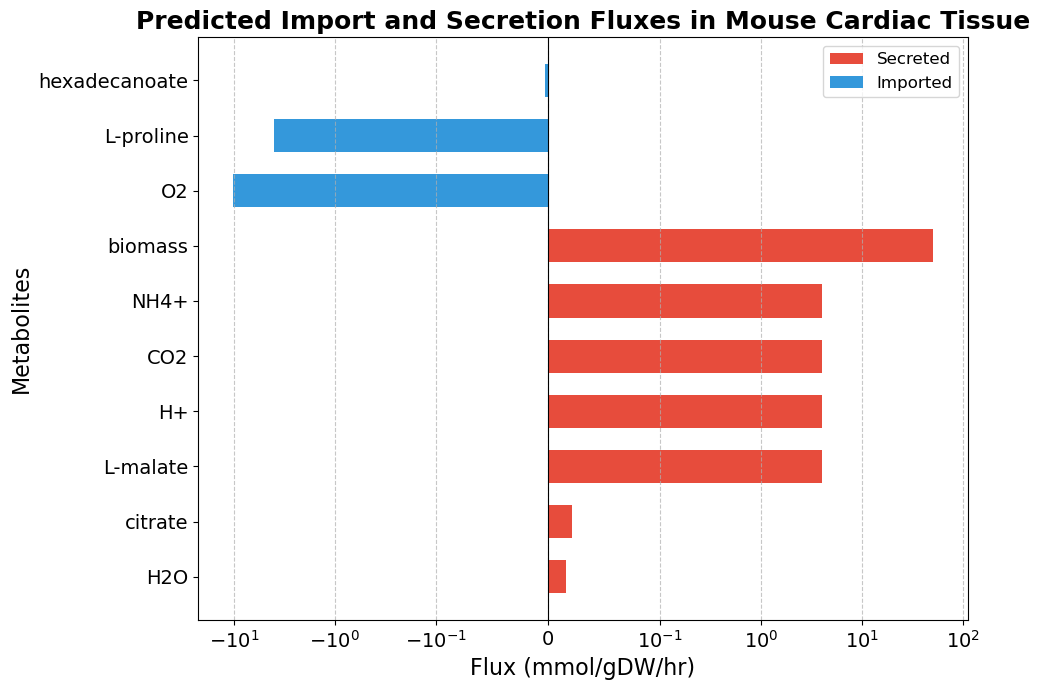

In [106]:
import matplotlib.pyplot as plt

# Sort metabolites and fluxes
sorted_uptake_metabolites, sorted_uptake_flux = zip(*sorted(zip(cardiac_uptake_metabolites, cardiac_uptake_flux), key=lambda x: x[1]))
sorted_secretion_metabolites, sorted_secretion_flux = zip(*sorted(zip(cardiac_secretion_metabolites, cardiac_secretion_flux), key=lambda x: x[1]))

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))  # Bigger figure for clarity

# Plot secreted (positive fluxes)
ax.barh(sorted_secretion_metabolites, sorted_secretion_flux, color='#e74c3c', label='Secreted', height=0.6)

# Plot imported (negative fluxes)
ax.barh(sorted_uptake_metabolites, sorted_uptake_flux, color='#3498db', label='Imported', height=0.6)

# Aesthetics
ax.set_xscale('symlog', linthresh=0.1)

ax.set_xlabel('Flux (mmol/gDW/hr)', fontsize=16)
ax.set_ylabel('Metabolites', fontsize=16)
ax.set_title('Predicted Import and Secretion Fluxes in Mouse Cardiac Tissue', fontsize=18, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.axvline(0, color='black', linewidth=0.8)  # line at x=0
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Tight layout
plt.tight_layout()

# Save higher quality
plt.savefig('mouse_cardiac_fluxes.svg', format='svg', dpi=300)

# Show
plt.show()


In [107]:
def print_result(solution):
    print(f"OF value :\t {solution[70]}")
    print(f"Complex I:\t{solution[107]}")
    print(f"Complex II:\t{solution[108]}")
    print(f"Complex III:\t{solution[109]}")
    print(f"Complex IV:\t{solution[110]}")
    print(f"Complex V:\t{solution[111]}")

488
Glycine import = -10.0, ATP = 50.0000
488
Glycine import = -9.0, ATP = 50.0000
488
Glycine import = -8.0, ATP = 50.0000
488
Glycine import = -7.0, ATP = 50.0000
488
Glycine import = -6.0, ATP = 50.0000
488
Glycine import = -5.0, ATP = 50.0000
488
Glycine import = -4.0, ATP = 50.0000
488
Glycine import = -3.0, ATP = 50.0000
488
Glycine import = -2.0, ATP = 50.0000
488
Glycine import = -1.0, ATP = 50.0000
488
Glycine import = 0.0, ATP = 50.0000


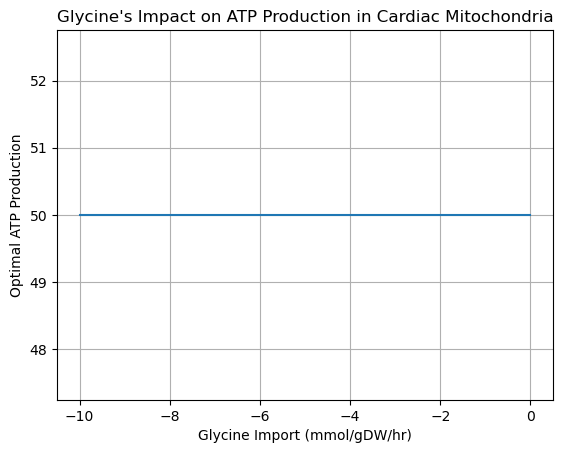

In [140]:
# Function to integrate data and set ATP as objective
import matplotlib.pyplot as plt

def perform_FBA(objective_id="OF_ATP_mitoMap"):
    model = cobra.io.read_sbml_model("4_universal_mito_model.xml")
    model.objective = model.reactions.get_by_id(objective_id)
    Eflux(model, heart_data, 50, 1, ignore_human=False, ignore_mus=True)
    return model

# Setup lists
glycine_import = []
optimal_atp_production = []

# Test different glycine import levels
for lb in np.linspace(-10, 0, 11):  # from -10 to 0
    model = perform_FBA()  # Reload constrained model each time

    # Set glycine import reaction bounds
    gly_rxn = model.reactions.get_by_id("EX_gly_e")
    gly_rxn.lower_bound = lb
    gly_rxn.upper_bound = 0

    # Optimize
    solution = model.optimize()

    # Save data
    glycine_import.append(lb)
    optimal_atp_production.append(solution.objective_value)
    print(f"Glycine import = {lb}, ATP = {solution.objective_value:.4f}")

# Plot result
plt.plot(glycine_import, optimal_atp_production)
plt.xlabel("Glycine Import (mmol/gDW/hr)")
plt.ylabel("Optimal ATP Production")
plt.title("Glycine's Impact on ATP Production in Cardiac Mitochondria")
plt.grid(True)
plt.show()

488
Glycine import = -10.0, ATP = 50.0000
488
Glycine import = -9.0, ATP = 50.0000
488
Glycine import = -8.0, ATP = 50.0000
488
Glycine import = -7.0, ATP = 50.0000
488
Glycine import = -6.0, ATP = 50.0000
488
Glycine import = -5.0, ATP = 50.0000
488
Glycine import = -4.0, ATP = 50.0000
488
Glycine import = -3.0, ATP = 50.0000
488
Glycine import = -2.0, ATP = 50.0000
488
Glycine import = -1.0, ATP = 50.0000
488
Glycine import = 0.0, ATP = 50.0000


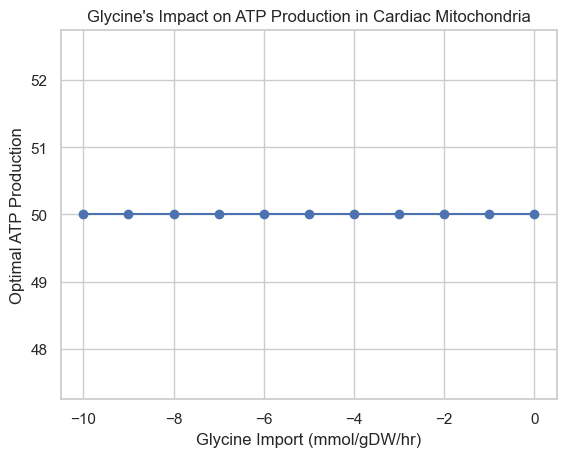

In [158]:
import matplotlib.pyplot as plt

def perform_FBA(objective_id="OF_ATP_mitoMap"):
    model = cobra.io.read_sbml_model("4_universal_mito_model.xml")
    model.objective = model.reactions.get_by_id(objective_id)
    Eflux(model, heart_data, 50, 1, ignore_human=False, ignore_mus=True)
    return model

glycine_import = []
optimal_atp_production = []

for lb in np.linspace(-10,0, 11):  # from -10 to 0
    model = perform_FBA()  # Reload constrained model each time

    gly_rxn = model.reactions.get_by_id("EX_gly_e")
    gly_rxn.lower_bound = lb  # <-- use the loop value
    gly_rxn.upper_bound = 0   # still keep upper bound at 0

    solution = model.optimize()

    glycine_import.append(lb)
    optimal_atp_production.append(solution.objective_value)
    print(f"Glycine import = {lb}, ATP = {solution.objective_value:.4f}")

# Plot
plt.plot(glycine_import, optimal_atp_production, marker='o')
plt.xlabel("Glycine Import (mmol/gDW/hr)")
plt.ylabel("Optimal ATP Production")
plt.title("Glycine's Impact on ATP Production in Cardiac Mitochondria")
plt.grid(True)
plt.show()


In [109]:
print(model.objective)

Maximize
1.0*OF_ATP_mitoMap - 1.0*OF_ATP_mitoMap_reverse_44b94


In [110]:
# Knock out serine to glycine pathway
model.reactions.get_by_id("GHMT2r").knock_out()

# Set glycine import to a fixed uptake
model.reactions.get_by_id("EX_gly_e").bounds = (-10, -10)

# Re-optimize
solution = model.optimize()
print("ATP after forcing glycine:", solution.objective_value)
print("Glycine flux:", solution.fluxes["GLYt2r"])


ATP after forcing glycine: 50.0
Glycine flux: 10.000000000000004


In [111]:
# Knock out serine to glycine pathway
model.reactions.get_by_id("GHMT2r").knock_out()

# Set glycine import to a fixed uptake
model.reactions.get_by_id("GLYt2r").bounds = (-10, -10)

# Re-optimize
solution = model.optimize()
print("ATP after forcing glycine:", solution.objective_value)
print("Glycine flux:", solution.fluxes["GLYt2r"])


ATP after forcing glycine: 50.0
Glycine flux: 10.000000000000004


/opt/anaconda3/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [144]:
# After solution
active_reactions = solution.fluxes[solution.fluxes.abs() > 1e-6]  # filter active reactions
print("Number of active reactions:", len(active_reactions))
print(active_reactions.sort_values(ascending=False))


Number of active reactions: 75
OF_ATP_mitoMap     50.000000
EX_biomass_e       50.000000
ATPtmB_mitoMap     40.055992
CV_mitoMap         25.100165
CI_mitoMap         19.907923
                     ...    
SUMt_mitoMap      -19.888015
SUCCt2m           -19.888015
FUM               -19.888015
MDH               -19.888015
Biomass_mitoMap   -50.000000
Name: fluxes, Length: 75, dtype: float64


488
Glycine import = 0.0, ATP production = 50.0000
488
Glycine import = -1.0, ATP production = 50.0000
488
Glycine import = -2.0, ATP production = 50.0000
488
Glycine import = -3.0, ATP production = 50.0000
488
Glycine import = -4.0, ATP production = 50.0000
488
Glycine import = -5.0, ATP production = 50.0000
488
Glycine import = -6.0, ATP production = 50.0000
488
Glycine import = -7.0, ATP production = 50.0000
488
Glycine import = -8.0, ATP production = 50.0000
488
Glycine import = -9.0, ATP production = 50.0000
488
Glycine import = -10.0, ATP production = 50.0000


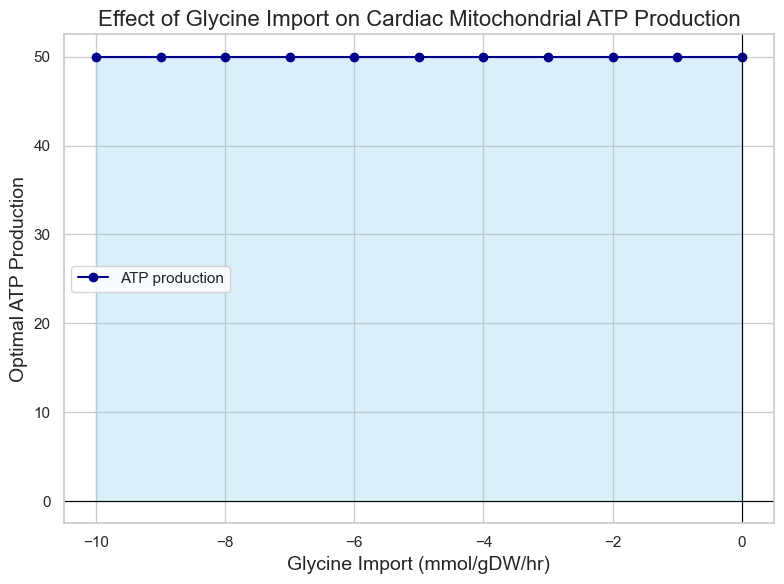

In [150]:
import cobra
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load model and setup
def perform_FBA(objective_id="OF_ATP_mitoMap"):
    model = cobra.io.read_sbml_model("4_universal_mito_model.xml")
    model.objective = model.reactions.get_by_id(objective_id)
    Eflux(model, heart_data, 50, 1, ignore_human=False, ignore_mus=True)
    
    # 🛑 Block proline import (so mitochondria can't cheat)
    model.reactions.get_by_id("EX_pro_L_e").bounds = (0, 0)
    
    return model

# Setup lists
glycine_import = []
optimal_atp_production = []

# Glycine import from 0 to -10
for lb in np.linspace(0, -10, 11):  # 0, -1, ..., -10
    model = perform_FBA()  # reload fresh model each time
    
    # Set glycine import bounds
    gly_rxn = model.reactions.get_by_id("EX_gly_e")
    gly_rxn.lower_bound = lb
    gly_rxn.upper_bound = 0  # always allow up to 0

    # Optimize
    solution = model.optimize()
    
    # Save results
    glycine_import.append(lb)
    optimal_atp_production.append(solution.objective_value)
    
    print(f"Glycine import = {lb:.1f}, ATP production = {solution.objective_value:.4f}")

# 🎨 Prettier Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))

plt.plot(glycine_import, optimal_atp_production, marker='o', color='darkblue', label='ATP production')
plt.fill_between(glycine_import, optimal_atp_production, color='skyblue', alpha=0.3)

plt.xlabel("Glycine Import (mmol/gDW/hr)", fontsize=14)
plt.ylabel("Optimal ATP Production", fontsize=14)
plt.title("Effect of Glycine Import on Cardiac Mitochondrial ATP Production", fontsize=16)
plt.axhline(0, color='black', linewidth=0.8)  # baseline
plt.axvline(0, color='black', linewidth=0.8)  # baseline
plt.legend()
plt.tight_layout()

# Save if needed
# plt.savefig("glycine_vs_atp.svg", format="svg")

plt.show()
